In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [6]:
#We read the RV datafile of HD81040.
df_raw = pd.read_csv('../../data/rvdata/hd81040.txt')

#We only take "bjd", "rv" and "e_rv" columns from the df_raw as follows. (We basically remove other columns)
df = df_raw[['bjd','rv','e_rv']]

#Then we define the columns as "time", "mnvel" and "errvel" as follows.
df.columns = ['time','mnvel','errvel']

df

,time,mnvel,errvel
0,2.451291e+06,49.319,0.012
1,2.451293e+06,49.312,0.014
2,2.451546e+06,49.088,0.009
3,2.452309e+06,49.399,0.012
4,2.452356e+06,49.412,0.021
5,2.452359e+06,49.363,0.012
6,2.452360e+06,49.391,0.011
7,2.452616e+06,49.119,0.011
8,2.452650e+06,49.126,0.011
9,2.452650e+06,49.129,0.013


In [7]:
#We take the Times, RV and RV Errors from the dataframe.
#Note that we are converting from km/s to m/s, hence the multiplication by 1000.
times = df.time.values
rv = (df.mnvel.values - np.median(df.mnvel.values)) * 1000
e_rv = df.errvel.values * 1000

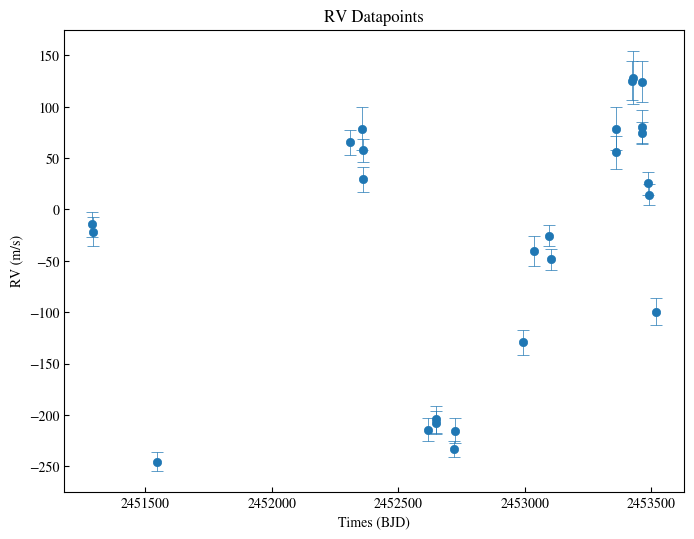

In [8]:
#We plot our RV data as follows.
fig, ax = plt.subplots(figsize = (8, 6))

ax.errorbar(times, rv, e_rv, marker = "o", lw = 0, mew = 0.5, capsize = 4, elinewidth = 0.5)

ax.set_title("RV Datapoints")
ax.set_xlabel("Times (BJD)")
ax.set_ylabel("RV (m/s)")

plt.show()

In [9]:
#Now we import the source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

import utils
import exomuse
import gaiasource
reload(gaiafit)

gaiafit, gaiasource, utils

list.remove(x): x not in list


ModuleNotFoundError: No module named 'gaiafit'

In [ ]:
#We then use "GaiaSource" object from "gaiasource.py"
#This object has functions to estimate Semi-Amplitude of RV and the Mass from the Gaia Thiele Innes Coefficients.
#We also input the stellar mass and error, which comes from Winn/Sozzetti 2006.
GS = gaiasource.GaiaSource('../../data/astrvdata/targets_winn.csv', source_index = 1, st_mass = 0.962, st_masserr = 0.001)

#We can then estimate the Mass and Semi-Amplitude as follows.
GS.df_campbell

In [ ]:
#Now, we can perform the Gaia-RV Joint Fit.
#For this we need:
    #1-) The prior file for the RV parameters.
    #2-) The RV data (which we have called on the previous cells)
    #3-) Gaia Input Data (in our case "targets_winn.csv")

#We call the prior file.
f = '../../data/astrvpriors/hd81040_priors_RVGaia.txt'

#We then use "LPFunctionGaiaRV" to do the fitting.
#Note that LPFunctionGaiaRV plots the priors.
L = gaiafit.LPFunctionRVGaia(times, rv, e_rv, 
                             filename = '../../data/astrvdata/targets_winn.csv', source_index = 1,
                             file_priors = f)

#We do a Fit for Gaia + RV as follows. (The function needs the Likelihood Function to work)
TF = gaiafit.GaiaFitRVGaia(L)

In [ ]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=2000,mc_iter=5000)

In [ ]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [ ]:
#We now aim to make the Flatchain and Posteriors.
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

In [ ]:
#A method for checking if the chains have converged is: Checking the GR statistic.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR STATISTICS")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
mcmc_help.plot_chains(chains_after_burnin,labels=TF.lpf.ps_vary.labels)
print(50 * "-")

In [ ]:
#We check the known Thiele Innes Coefficient values from Gaia.
TF.lpf.df_known

In [ ]:
#We also check the Covariance Matrix, "C Matrix".
TF.lpf.C

In [ ]:
#We can also check the posteriors as follows.
df_post, df_mean = TF.calculate_derived_params(df_post)
df_post

In [ ]:
#We can check the parameter posteriors from the fit results as follows.
df_mean[['Labels','values']]

In [ ]:
# #We can also check the Z-score panel with the following.
# #Note that Z-Score panel shows the standard deviations of the parameters from the respective parameters mean.
# TF.plot_zscore_panel();

In [ ]:
#We then plot the Corner plot.
# import corner
# corner.corner(df_post.values,
#        show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

In [ ]:
# # Plot corner plot
# fig = mcmc_help.plot_corner(chains_after_burnin,
#        show_titles=True,labels=np.array(TF.lpf.ps_vary.descriptions),title_fmt='.1f',xlabcord=(0.5, -0.2),
#        truths=[0.741,5.16*316.82,0.5439,113.846,0.149,126.0507,655.57,-138.5,28.99,0])

In [ ]:
# Print median values
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals

In [ ]:
import utils
TITLE = 'BD, with bulk RV'
NUMMODELS = 400
shadecolor="black"

###################
times1 = np.linspace(TF.lpf.data['x'][0]-0.02,TF.lpf.data['x'][-1]+0.02,500)
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
t1_mod = np.linspace(times1.min()-0.02,times1.max()+0.02,300)
rv_50 = TF.lpf.compute_total_model(pv_50,t1_mod)

# Plot random samples
fig, ax = plt.subplots(dpi=200)

#################
# Plot data
#################
markercolor="black"
ax.errorbar(TF.lpf.data['x'],TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=0.5,capsize=4,lw=0,mew=0.5,color=markercolor,markersize=3)
ax.plot(t1_mod,rv_50,color="crimson",
        label=r'50% Model',lw=2.,zorder=10)

#################
# Sample models
#################
mmodel1 = []
for i in range(NUMMODELS):
    if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)
#################

ax.fill_between(t1_mod,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='1$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
ax.fill_between(t1_mod,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),
                alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)
ax.legend(loc='upper right')
ax.set_xlabel('Time [BJD]',labelpad=0)
ax.set_ylabel('RV [m/s]',labelpad=0)
ax.set_title(TITLE)
utils.ax_apply_settings(ax)

plt.show();